In [40]:
colab = False
if colab:
    from google.colab import drive
    drive.mount('/content/drive')

In [41]:
if colab:
    import os
    os.chdir('/content/drive/My Drive/P3')

# Watch out for unexpected movie recommendations !

# Introduction

Our primary goal is to enhance content-based recommendations by uncovering hidden topics within movie plots using Latent Dirichlet Allocation (LDA). By identifying these latent themes, we can move beyond conventional genre-based recommendations to suggest movies with deeper, thematic similarities.

<div style="border-left: 6px solid rgba(69, 157, 185, 1);border-radius:5px; box-shadow: 3px 3px 3px rgba(221, 221, 221, 1);" >
    <p style="background-color: rgba(69, 157, 185, 0.1); font-weight:bold; padding: 8px 0 8px 15px;">Analysis</p>
    <div style="padding: 0 0 2px 10px;">
    
**What will be covered :**
- **Part 1 :** Data Pre-processing (covered in data_preprocessing.ipynb)
- **Part 2 :** Data exploration
- **Part 3 :** Latent Dirichlet Allocation (LDA)
- **Part 4 :** Are topics linked to genres/labels?
- **Part 5 :** Recommendation!!!
- **Part 6 :** Do topics capture enough similarity?
- **Part 7 :** Additional features Analysis

</div></div>
<br/>

---

### Import libraries

In [42]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from collections import Counter
from src.utils.helpers import *
import pickle
import plotly.express as px
from imdb import IMDb
import re
from gensim.models import LdaModel
# Worcloud
from ipywidgets import interact, widgets

# Linear Regression 
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from scipy.sparse import hstack

# LDA visualisation
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

# PCA
from sklearn.decomposition import PCA

# Part 2: Data Exploration

*Comment: Part 1 with all the preprocessing of the dataset can be found in data_preprocessing.ipynb*

With the preprocessing done, we remain with three clean dataframes:
| Dataframe        | Description                                                                      | Number of movies |
|------------------|----------------------------------------------------------------------------------|------------------|
| movies_ratings   | contains all movies with our characteristics of intrest but with some NaN values | 14686            |
| LDA_df           | contains only movies (rows) with no NaN values in the movie genres column        | 14604            |
| features_df      | contains only movies (rows) with no NaN values in any column                     | 5904             |



Let's now explore some of their characteristics

### Movies' summaries exploration

In [43]:
# Load LDA_df
LDA_df = pd.read_csv('Data/LDA_df.csv') #Import our dataframe

# Lengths of each plot synopsis
summary_lengths = LDA_df['plot_synopsis'].apply(len)

# Stats of plot synopsis length
LDA_df['plot_synopsis'].apply(lambda x: len(x)).describe().round()

count    14604.0
mean      5427.0
std       5028.0
min        656.0
25%       2616.0
50%       4000.0
75%       6169.0
max      63959.0
Name: plot_synopsis, dtype: float64

Comment
There is a difference between the mean and the median. Let's have a look at the distribution

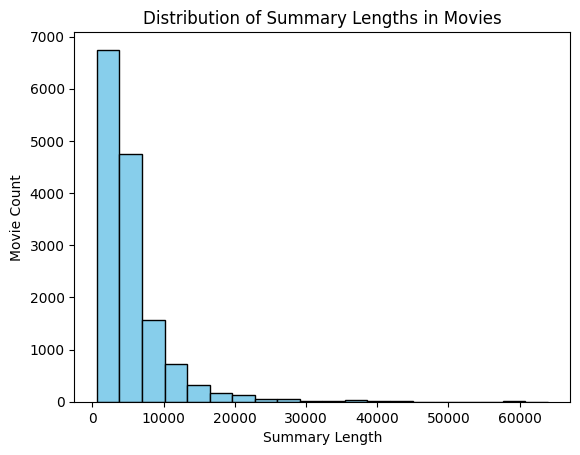

In [44]:
# Plot the histogram
plt.hist(summary_lengths, bins=20, color='skyblue', edgecolor='black')
plt.ylabel('Movie Count')  # y-axis will be the count of movies
plt.xlabel('Summary Length')  # x-axis will be the length of the summaries
plt.title('Distribution of Summary Lengths in Movies')
plt.show()

### Movies' genres exploration

Number of unique genres: 7970


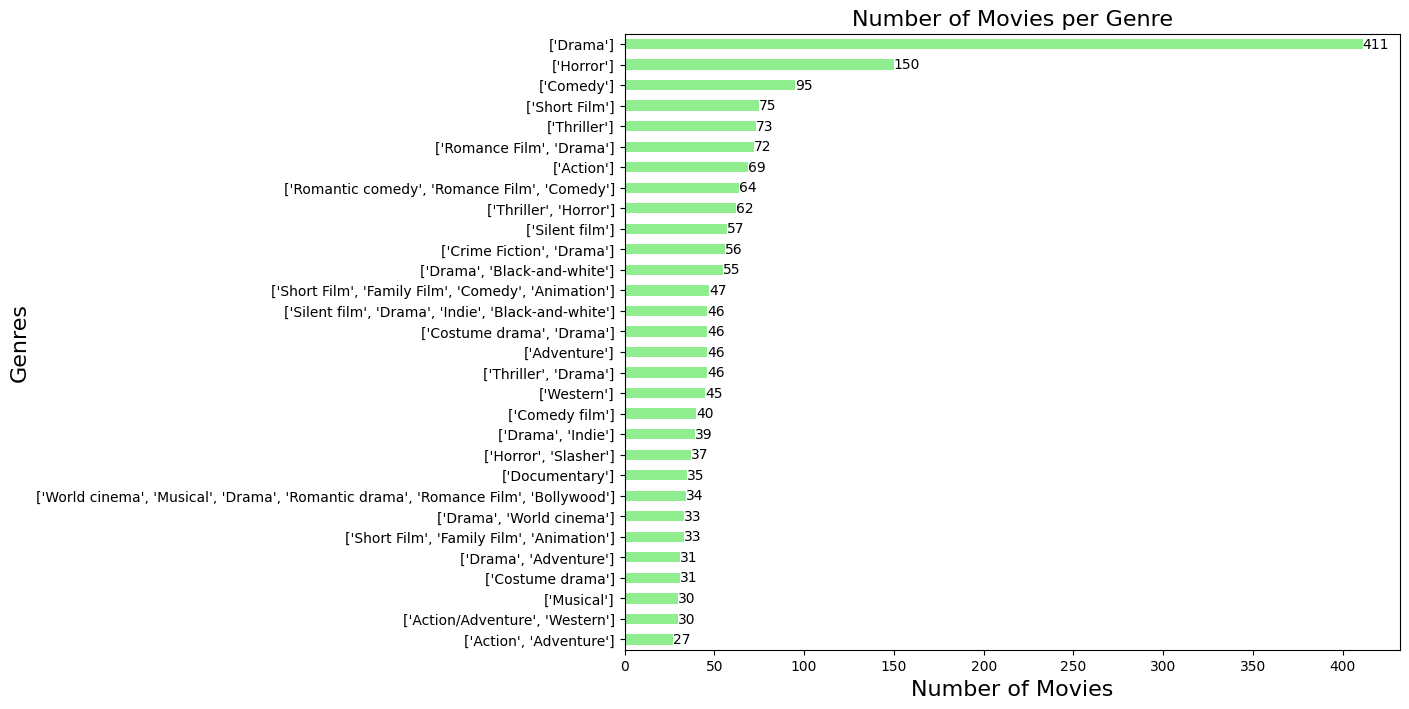

In [45]:
all_genres = LDA_df['Movie genres'].explode() # Changes elements from a list to a row

num_unique_genre = all_genres.nunique() # Creates list which each type of genre in all_genres
print("Number of unique genres:", num_unique_genre)

# Plot the number of movies per top 30 genres

genres_counts = all_genres.value_counts()

plt.figure(figsize=(10, 8))
bars = genres_counts.head(30).sort_values(ascending=True).plot(kind='barh', color='lightgreen') # kind='barh' allows us to flip the axis
for index, value in enumerate(genres_counts.head(30).sort_values(ascending=True)):
    plt.text(value, index, str(value), va='center')
plt.xlabel('Number of Movies', fontsize=16)
plt.ylabel('Genres', fontsize=16)
plt.title('Number of Movies per Genre', fontsize=16)
plt.show()

Drama stands tall as the top movie genre, with Thriller and Comedy close behind, winning over audiences with laughs and love. It’s no surprise these genres have something for everyone. Action, Romance, Crime and Horror also shine, showing that people enjoy excitement, love and scaring themselves. On the other hand, niche genres like ‘Costume Drama’ and 'Western' are less common, loved by smaller, more specific audiences.

*Here we decided to show only the top 30 genres to keep the chart clear and easy to read.*

In [46]:
LDA_df.head(3)

imdb_id                                     Movie name  \
0  tt1733125  Dungeons & Dragons: The Book of Vile Darkness   
1  tt0033045                     The Shop Around the Corner   
2  tt0113862                             Mr. Holland's Opus   

                                       plot_synopsis  \
0  Two thousand years ago, Nhagruul the Foul, a s...   
1  Matuschek's, a gift store in Budapest, is the ...   
2  Glenn Holland, not a morning person by anyone'...   

                                     tags  \
0                                violence   
1                                romantic   
2  inspiring, romantic, stupid, feel-good   

                                        Movie genres  averageRating  
0                                        ['Fantasy']            4.4  
1  ['Romantic comedy', 'Workplace Comedy', 'Black...            8.0  
2  ['Inspirational Drama', 'Family Film', 'Drama'...            7.3

In [47]:
#generate_interactive_wordcloud(file=LDA_df, target1="Movie genres", target2="plot_synopsis", output_html="interactive_wordclouds.html", top_n=20)


From the word clouds across different genres, we observe that certain words, such as 'find,' 'tell,' 'one,' and 'see,' appear consistently across all genres. This is expected, as these are commonly used words. However, their large presence makes it difficult to discern clear trends or distinctions among the genres. We will handle this before performing LDA.

# Part 3: Latent Dirichlet Allocation (LDA)
LDA offers a way to cluster together movies that reflect similar themes, based on textual descriptions. The model does unsupervised learning, as the themes fo the movies are not known. Our problem was that the movie summaries only give too few informations to use LDA. That's why we extracted the synopsis of the movies through another dataset called "Movie Plot Synopses with Tags" (MPST). Those synopsis are around 10 times longer than the summaries, giving way more informations to the LDA model.

## 3.1 LDA Preprocessing
comment: This part is done in the file model_training.ipynb

## 3.2 Number of topics selection

The main parameter to give when it comes to LDA is the number of topics LDA will produce. To select the number of topics we need a coherence score, quantifying how good are the topics formed by a LDA model. Gensim provides a function to get a coherence score called $C_v$ but after checking some documentation [check here](https://www.baeldung.com/cs/topic-modeling-coherence-score), we came to the conclusion that Gensim function wasn't very reliable. So we build our own coherence score using the Word2Vec model. Word2Vec is a NLP technique which consists in representing words with vectors that capture the meaning of the word. This means two words with similar meaning (i.e. prince and king) will be close in the vector space. For each LDA model, we can attribute a coherence score based on the intra/inter similarity between topics with the following formula :

$C_{sim} = \frac{1}{N-1}\sum_{i ≠ j}\frac{\frac{\text{intra(i)} + \text{intra(j)}}{2}}{\text{inter(i,j)}}$

with $N$ the number of topics, $\text{intra(i)}$ the average similarity between words of topic $i$ and $\text{inter(i, j)}$ the average similarity between words of topic $i$ and $j$.

The working principle is quite intuitive:
* Maximize intra-topic similarity: similarity of words in the same topic.

* Minimize inter-topic similarity: the similarity of words across different topics.

The function to get the similarity coherence score $C_{sim}$ is available in the `utils/helpers.py` file.

### Run LDA for various number of topics 
Comment: Also done in model_training.ipynb

Thus we simply import the relevant results

In [48]:
# Load the dictionary
from gensim.corpora import Dictionary
dictionary = Dictionary.load("Data/dictionary.dict")

# Load the corpus
from gensim.corpora import MmCorpus
corpus = MmCorpus("Data/corpus.mm")

# Load coherence scores /topic
with open('Data/coherence_sim.pkl', "rb") as file:
    coherence_sim = pickle.load(file)

Let's see what number of topics has the best coherence.

We observe that indeed both metrics don't give similar results for all the number of topics. We decide to prioritize the similarity coherence score $C_{sim}$ as $C_v$ isn't reliable. To maximize coherence we choose the number of topics to be **15**. We will use this model for the rest of the project. Note that we didn't go further than 19 topics in our exploration because we preferred anyway to keep the method clear and concise for the site. 

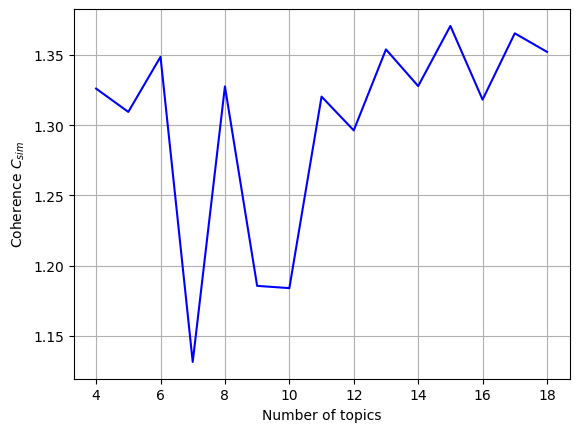

In [49]:
#Figure for the site, clearer
topic_number = range(4, 19, 1)
plt.plot(topic_number, coherence_sim, 'b', label=r'$C_{sim}$')
plt.xlabel('Number of topics')
plt.ylabel(r'Coherence $C_{sim}$')
plt.grid()

_Load the LDA model with 15 topics_

In [50]:
lda_model = LdaModel.load("src/models/lda_model15.model")

Let's see what's the word distribution for each topic :

In [51]:
for topic_id, topic_words in lda_model.print_topics(num_words=8):
    print(f"Topic {topic_id}: {topic_words}")

Topic 0: 0.006*"police" + 0.006*"car" + 0.005*"murder" + 0.004*"killer" + 0.004*"shoot" + 0.004*"run" + 0.003*"reveal" + 0.003*"escape"
Topic 1: 0.005*"murder" + 0.005*"say" + 0.005*"woman" + 0.004*"ask" + 0.003*"case" + 0.003*"look" + 0.003*"work" + 0.003*"police"
Topic 2: 0.012*"say" + 0.008*"ask" + 0.008*"get" + 0.008*"room" + 0.007*"house" + 0.007*"look" + 0.007*"door" + 0.006*"run"
Topic 3: 0.004*"Beast" + 0.004*"barricade" + 0.004*"life" + 0.003*"escape" + 0.003*"Marius" + 0.003*"house" + 0.003*"daughter" + 0.003*"order"
Topic 4: 0.005*"game" + 0.005*"say" + 0.004*"team" + 0.004*"ask" + 0.004*"Lord_Blackwood" + 0.004*"Lord" + 0.003*"run" + 0.003*"room"
Topic 5: 0.007*"Macbeth" + 0.006*"king" + 0.005*"son" + 0.005*"King" + 0.004*"army" + 0.004*"prophecy" + 0.004*"castle" + 0.004*"order"
Topic 6: 0.009*"car" + 0.009*"say" + 0.007*"ask" + 0.007*"get" + 0.006*"police" + 0.006*"money" + 0.006*"gun" + 0.005*"shoot"
Topic 7: 0.020*"Sir" + 0.004*"musketeer" + 0.003*"ask" + 0.003*"uncle" 

From this list of words we observe that the preprocessing isn't perfect because some character names still remain as they were not recognize by the spacy analyzer. However we can still easily dicerner some topics. For example the topic 0 seems to describe crime movies, with keywords like police, murder, shoot and car. We asked the NLP AI Chat-GPT ([source](https://chatgpt.com)) to name each topic depending on its words distribution. Here are the names of each topic:

| Topic | Keywords                    | Theme                                  |
|-------|-----------------------------|----------------------------------------|
| 0     | police, car, murder         | Crime and Pursuit                      |
| 1     | murder, woman, case         | Investigative Drama                    |
| 2     | say, ask, room              | Domestic Suspense                      |
| 3     | Beast, barricade, escape    | Struggle and Sacrifice                 |
| 4     | game, team, treasure        | Adventure and Teamwork                 |
| 5     | Macbeth, king, prophecy     | Shakespearean Power Struggles          |
| 6     | car, police, money          | Urban Crime and Violence               |
| 7     | Sir, musketeer, airship     | Historical and Heroic Tales            |
| 8     | Lincoln, look, life         | Identity and Discovery                 |
| 9     | say, money, love            | Emotional Conflict and Drama           |
| 10    | house, vampire, family      | Supernatural and Gothic                |
| 11    | love, family, school        | Family and Everyday Life               |
| 12    | guard, musketeer, sword     | Adventure and Loyalty                  |
| 13    | say, look, castle           | Drama and Character Interaction        |
| 14    | escape, attack, team        | Action and Strategy                    |


Let's add to the dataframe the distribution of topics for each movie, and the main topic (the one with highest distribution).

In [52]:
movie_final = pd.read_csv('Data/LDA_df.csv') # Import LDA_df to further modify it

In [53]:
topic_distrib = [sorted(lda_model.get_document_topics(doc), key=lambda x: x[1], reverse=True) for doc in corpus]
movie_final.insert(loc=len(movie_final.columns), column='Topics', value=topic_distrib)
topic_dic = {
    0: 'Crime and Pursuit', 1: 'Investigative Drama', 2: 'Domestic Suspense', 3: 'Struggle and Sacrifice',
    4: 'Adventure and Teamwork', 5: 'Shakespearean Power Struggles', 6: 'Urban Crime and Violence',
    7: 'Historical and Heroic Tales', 8: 'Identity and Discovery', 9: 'Emotional Conflict and Drama',
    10: 'Supernatural and Gothic', 11: 'Family and Everyday Life', 12: 'Adventure and Loyalty',
    13: 'Drama and Character Interaction', 14: 'Action and Strategy',
}
movie_final['Main Topic'] = movie_final['Topics'].apply(lambda x : topic_dic[x[0][0]])
movie_final.head(3)

imdb_id                                     Movie name  \
0  tt1733125  Dungeons & Dragons: The Book of Vile Darkness   
1  tt0033045                     The Shop Around the Corner   
2  tt0113862                             Mr. Holland's Opus   

                                       plot_synopsis  \
0  Two thousand years ago, Nhagruul the Foul, a s...   
1  Matuschek's, a gift store in Budapest, is the ...   
2  Glenn Holland, not a morning person by anyone'...   

                                     tags  \
0                                violence   
1                                romantic   
2  inspiring, romantic, stupid, feel-good   

                                        Movie genres  averageRating  \
0                                        ['Fantasy']            4.4   
1  ['Romantic comedy', 'Workplace Comedy', 'Black...            8.0   
2  ['Inspirational Drama', 'Family Film', 'Drama'...            7.3   

                                              Topics                Main Topic  
0  [(10, 0.7467012), (14, 0.103723414), (5, 0.072...   Supernatural and Gothic  
1  [(11, 0.75163704), (1, 0.11554898), (6, 0.0902...  Family and Everyday Life  
2  [(11, 0.80156773), (9, 0.12116508), (2, 0.0624...  Family and Everyday Life

## 3.3 Topics analysis
Are the topics discovered by LDA completely new ? Or are they reflecting genres or other characteristics ?

### 3.3.1 PCA to check topic distinctions

The topics are formatted as `Tuples` we will convert to `np.array` which is easier to compute the distance.

In [54]:
# Ensure all rows in 'Topics' have 15 elements
num_topics = 15

def format_topics(topics, num_topics=15):
    topic_dict = {topic: prob for topic, prob in topics}
    return [topic_dict.get(i, 0) for i in range(num_topics)]

# Convert to list
movie_final['Topics'] = movie_final['Topics'].apply(format_topics)

# Convert to array
movie_final['Topics'] = movie_final['Topics'].apply(np.array)

# Check results
print(movie_final['Topics'].head().value_counts())

Topics
[0.0, 0.0, 0.0, 0.0, 0.07204169034957886, 0.0724283754825592, 0.0, 0.0, 0.0, 0.0, 0.746701180934906, 0.0, 0.0, 0.0, 0.10372341424226761]                        1
[0.0, 0.1155489832162857, 0.04013889655470848, 0.0, 0.0, 0.0, 0.090211883187294, 0.0, 0.0, 0.0, 0.0, 0.7516370415687561, 0.0, 0.0, 0.0]                         1
[0.0, 0.0, 0.06243697181344032, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.12116508185863495, 0.0, 0.8015677332878113, 0.0, 0.013975013047456741, 0.0]                     1
[0.056060466915369034, 0.050623293966054916, 0.0, 0.0, 0.0, 0.0, 0.6062086224555969, 0.0, 0.0, 0.0, 0.0, 0.17218396067619324, 0.0, 0.0, 0.10554035753011703]    1
[0.056074757128953934, 0.05076228454709053, 0.0, 0.0, 0.0, 0.0, 0.606146514415741, 0.0, 0.0, 0.0, 0.0, 0.17213024199008942, 0.0, 0.0, 0.1055135652422905]       1
Name: count, dtype: int64


In [55]:
# Extract topic probabilities
topic_probabilities = np.array(movie_final['Topics'].tolist())

# Perform PCA to reduce from 15 to 3 dimensions only
pca = PCA(n_components=3)
reduced_data = pca.fit_transform(topic_probabilities)

# Add reduced dimensions to the dataframe
movie_final['PC1'] = reduced_data[:, 0]
movie_final['PC2'] = reduced_data[:, 1]
movie_final['PC3'] = reduced_data[:, 2]

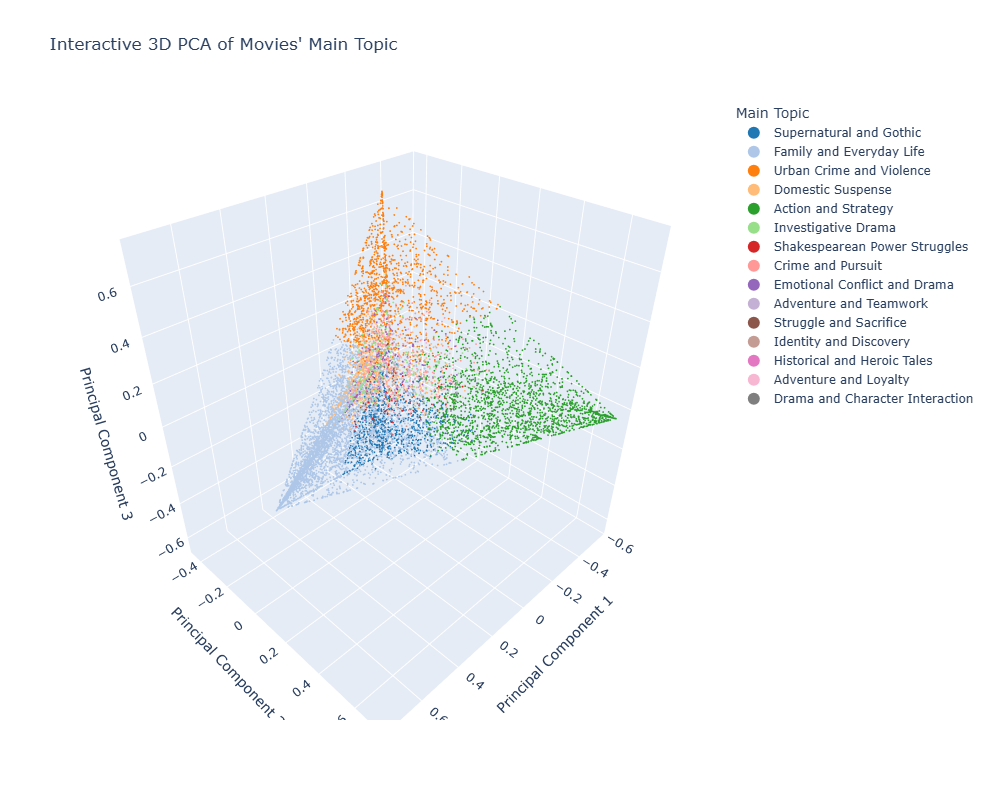

In [56]:
# Create an interactive 3D scatter plot showing the movies grouped by topics

# Generate a 15-color palette
seaborn_palette = sns.color_palette("tab20", n_colors=15).as_hex() # tab20 palette for maximum differentiation between colors

# Create the 3D scatter plot
fig = px.scatter_3d(
    movie_final,
    x='PC1',
    y='PC2',
    z='PC3',
    color='Main Topic',  # Color by 'Main Topic'
    color_discrete_sequence=seaborn_palette,  # Use the custom palette
    title="Interactive 3D PCA of Movies' Main Topic",
    labels={'PC1': 'Principal Component 1', 'PC2': 'Principal Component 2', 'PC3': 'Principal Component 3'},
    width=1200,  # Width of the plot
    height=800   # Height of the plot
)


# Update the trace to make sure the legend dots are a constant size
fig.update_traces(
    marker=dict(size=1),  # Set size for plot dots
    selector=dict(mode='markers')
)

# Fix the legend dots size to be constant
fig.update_layout(
    legend=dict(
        itemsizing='constant',  # Keep the legend items a constant size
        tracegroupgap=0         # Adjust spacing between legend entries
    )
)

# Show the plot
fig.show()

Here the 15 dimensions of the topics were reduced to 3 using PCA. This allows to see the clustering of topics supporting the evidence that they are seperated from each other. The vertices that appear represent dominant topics in the data because they are far apart from any other topic. Edges represent movies that lie between two dominant topics. Faces of the shape represent movies with mixtures of three topics. These movies share moderate probabilities for three topics but are not as extreme as those on the vertices. Movies located inside the shape have a probability spread more evenly distributed across multiple topics. These are likely movies that don't clearly belong to one single topic but share features with many topics.

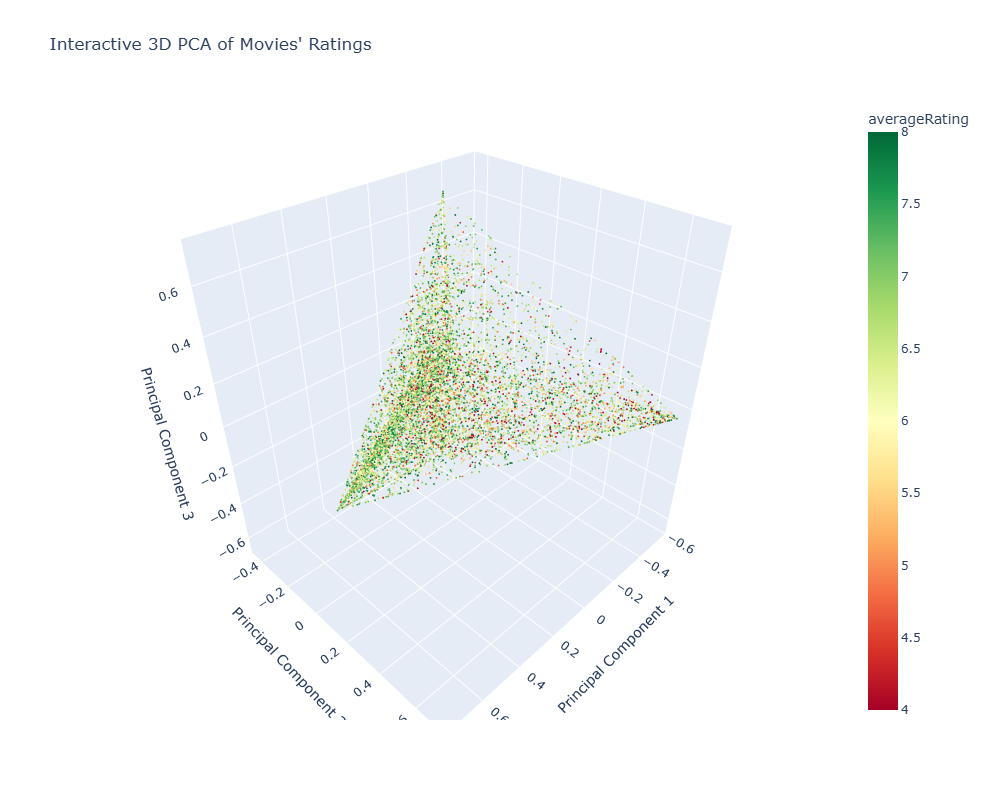

In [57]:
# Create an interactive 3D scatter plot showing the movies grouped by topics but displaying their average rating

fig = px.scatter_3d(
    movie_final,
    x='PC1',
    y='PC2',
    z='PC3',
    color='averageRating',  # Use the IMDb Rating for color coding
    title="Interactive 3D PCA of Movies' Ratings",
    labels={'PC1': 'Principal Component 1', 'PC2': 'Principal Component 2', 'PC3': 'Principal Component 3'},
    width=1200,
    height=800,
    color_continuous_scale='RdYlGn',  # Color scale from red (low) to green (high)
    range_color=[4, 8]  # Restrict color scale to values between 4 and 8 since our ratings distribution ressembles a gaussian with mean of 6.37
)

# Update the trace to adjust the colorbar display
fig.update_traces(
    marker=dict(
        size=1,  # Set dynamic size for plot dots
        colorbar=dict(
            title="IMDb Rating",
            tickvals=[4, 6, 8],  # Customize tick values within the restricted range
            ticktext=['4', '6', '8']  # Labels for the ticks
        )
    ),
    selector=dict(mode='markers')
)

# Fix the legend dots size to be constant (e.g., size 10)
fig.update_layout(
    legend=dict(
        itemsizing='constant',  # Keep the legend items a constant size
        tracegroupgap=0         # Adjust spacing between legend entries
    )
)

# Show the figure
fig.show()


This is the same plot as the one above except that instead of the main topic of the movie, it displays its average rating. There are no clear trends that appear when looking at this graph suggesting that any topic can get both bad and great reviews depending on the movie.

### 3.3.2 Topics interpretation with pyLDAvis

In [58]:
# Common way of showing results from an LDA analysis

# Prepare pyLDAvis visualisation
lda_vis_data = gensimvis.prepare(lda_model, corpus, dictionary)

# Display the visualisation
pyLDAvis.display(lda_vis_data)

/opt/jlab-env-3.12.5/lib/python3.12/site-packages/joblib/externals/loky/backend/fork_exec.py:38: DeprecationWarning:

This process (pid=126) is multi-threaded, use of fork() may lead to deadlocks in the child.

/opt/jlab-env-3.12.5/lib/python3.12/site-packages/joblib/externals/loky/backend/fork_exec.py:38: DeprecationWarning:

This process (pid=126) is multi-threaded, use of fork() may lead to deadlocks in the child.

/opt/jlab-env-3.12.5/lib/python3.12/site-packages/pytz/tzinfo.py:27: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  _epoch = datetime.utcfromtimestamp(0)
/opt/jlab-env-3.12.5/lib/python3.12/site-packages/pytz/tzinfo.py:27: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetime

#### How to interact with the graph
Interacting with the Visualisation
* Selecting a topic (Click on a circle): updates the right panel to show the most relevant terms for that specific topic.
* Hovering over a term (Right Panel): highlights its contribution to the topic (red bar) and its overall frequency (grey bar).

#### How to interpret the graph 

LEFT PANEL - Intertopic Distance Map
        
Each movie synopsis in the corpus can be represented as a probability distribution over all topics. This creates a high-dimensional space where each axis corresponds to a topic. PCA is used to reduces this space into just two dimensions (PC1 and PC2)

Each circle corresponds to a topic generated by the LDA model. 
The position and distance between the circles show how similar the topics are to each other. 
Closer circles mean topics share more overlapping terms, while distant circles represent more distinct topics.

The size of a circle reflects the prevalence of the topic in the corpus.
Larger circles indicate more synopsis are associated with that topic meaning it appears more often.

RIGHT PANEL - Term Relevance and Bar Chart (Right Panel)

This panel lists the most important words for the currently selected topic. For each word, the bar chart shows two values:
* Red Bar: Frequency of the term in the selected topic.
* Grey Bar: Frequency of the term across all topics (corpus-wide).

Relevance metric (λ):
Adjusting λ balances the trade-off between:
* λ=0: Showing terms exclusive to the topic.
* λ=1: Showing terms based on their overall frequency across the entire corpus.


#### Graph analysis

The topics are ordered based on the percentage of tokens that were used to create them. By setting the relevance to 1 (λ=1) and then hovering over the words of a certain topic we can see how much each topic uses this word. Words like "army" appear in most topics. But in order to differentiate each other, the topics also have words specific to them that can be seen when setting the relevance to 0 (λ=0). We can then see that for Topic 7, "MacBeth" is an important word specific to this topic.
While only topics 11, 10 and 7 are isolated form the rest all other topics are still very different from each other but this is not evident since the 15 dimensions of the topics are projected to only 2 dimensions.


# Part 4: Are topics linked to genres/labels?
### Networks between topics
We begin with networks, where two topics have an edge if they have a genre in common. This is done starting with a bipartite graph between topics and genres. To link a topic $i$ with a genre $j$, we check how often this genre $j$ appear for movies with topic $i$ as main topic. If this proportion is larger than a chosen threshold, we link the topic to the genre. Then we project the bipartite graph to keep only topics as nodes. The edges then represent how many genres two topics have in common. During this procedure we calculate aswell the average probability to have a link between a topic and a genre, if genres were distributed randomly. Comparing this to the proportion of links we actually have in the bipartite graph allows to measure how our topics are representing genres. Note that the size of nodes represent the proportion of movies having this topic as main topic.

In [59]:
draw_bipartite(movie_final, topic_dic, threshold=0.29, mode='genres')

NameError: name 'draw_bipartite' is not defined

In [ ]:
[link_probability_random, link_proportion] = draw_network_genre(movie_final, topic_dic, threshold=0.29)
print(f'The probability of link if topics were independant of genres would be {round(link_probability_random*100,3)}%.')
print(f'The proportion of link between topics and genres is {round(link_proportion*100,3)}%.')

We observe that we have way more links than if our genres were randomly distributed. This means that our topics reflects to some extend the genres. We also see that the `Family and Everyday Life` is the predominant main topic in our dataset. `Action and Strategy` and `Urban Crime and Violence` have the most genres in common.

### Let's do the same analysis with the labels of the MPST dataset added earlier instead of genres.

In [ ]:
[link_probability_random, link_proportion] = draw_network_tags(movie_final, topic_dic, threshold=0.25)
print(f'The probability of link in a random relation between topics and labels would be {round(link_probability_random*100,3)}%.')
print(f'The proportion of link between topics and labels is {round(link_proportion*100,3)}%.')

The two percentages are surprisingly close. This means labels are statistically random for our topics. We thus can't infer any trends between topics and tags from this network.

# Part 5: Recommendations!!!

Now that we have discovered new information about a movie. Let's put it to use for movie recommendation. Give us a movies you like, you will get a new movie recommendation by picking the most similar movie (closest topics).

In [ ]:
def format_topics(topics, num_topics=15):
    topic_dict = {topic: prob for topic, prob in topics}
    return [topic_dict.get(i, 0) for i in range(num_topics)]

# Convert to list
movie_final['Topics'] = movie_final['Topics'].apply(format_topics)

# Convert to array
movie_final['Topics'] = movie_final['Topics'].apply(np.array)

# Check results
print(movie_final['Topics'].head().value_counts())

All topics are well formatted let's now compute the most similar movie with a recommendation algorithm

In [ ]:
def recommend_similar_movie(movie_name):

  # Check that movie name is in the dataframe
  if not (movie_final['Movie name'] == movie_name).any():
    return "Error: This Movie is either mispelled or not in the database."

  else:
    # From movie name get topic score
    movie_infos = movie_final[movie_final['Movie name'] == movie_name].iloc[0]
    other_movies = movie_final[~(movie_final['Movie name'] == movie_name)]

    # Euclidean distances
    distances = other_movies['Topics'].apply(
        lambda x: np.linalg.norm(x - movie_infos['Topics'])
    )

    closest_movie = distances.nsmallest(1).index[-1]
    return print("You should watch" , other_movies['Movie name'].iloc[closest_movie], "(imdb_id:", other_movies['imdb_id'].iloc[closest_movie],")" )

# Prompt the user for input
movie_name = input("Please enter a  movie name: ") # Scarface, Dungeons & Dragons: The Book of Vile Darkness

recommend_similar_movie(movie_name)


# Part 6: Similarity Analysis
### Are Topics enough for recommandation ?

We will first start by make the assumption that similar topics have similar ratings. In fact if we do not want to recommend movies based on the highest rating, if you liked a cheesy low-rated christmas movie you might not want to watch the highest Can prized movie next. We will first analyse if this statement is true for genres and then see if similar movies have similar ratings using dimensionality reduction analysis.

## Part 6.1: Are ratings similar accross genres?
First we will start by analyzing how the ratings change across genres. 

In [ ]:
# Import dataset and format is
features_df = pd.read_csv('Data/features_df.csv')

# Plot the ratings distribution across top genres
plot_ratings_dropdown(features_df, genre_column='Movie genres', rating_column='averageRating', top_n=20, output_html="ratings_dropdown.html")

In [ ]:
# Use the top 20 genres for the plot
top_20_genres = genres_counts.index[:20]

# Filter the data for only the top 10 genres
filtered_data = features_df[features_df['Movie genres'].isin(top_20_genres)]

# Generate a palette with unique colors for the top 10 genres
palette = sns.color_palette("tab20", len(top_20_genres))

# Plot ratings distribution across the top 10 genres
plt.figure(figsize=(12, 8))
sns.boxplot(
    data=filtered_data,
    x='Movie genres',
    y='averageRating',
    order=top_20_genres,
    palette=palette
)

# Label the plot
plt.xticks(rotation=45, ha="right")
plt.title("Ratings Distribution Across Top 20 Movie Genres", fontsize=16)
plt.xlabel("Movie Genres", fontsize=14)
plt.ylabel("IMDB Ratings", fontsize=14)
plt.tight_layout()
plt.show()

The boxplot shows the IMDb ratings distribution across the top 20 movie genres, and we can observe clear trends across genres. Most genres have median ratings between 6 and 7, suggesting that movies generally receive moderate reviews. Genres like Drama, Thriller, and Comedy show a wider spread of ratings, indicating that audience opinions on these movies vary significantly. In contrast, genres such as Horror and Fantasy tend to have lower median ratings, with a higher number of poorly rated movies. On the other hand, genres like Mystery, Science Fiction, and Crime Fiction show slightly higher median ratings and fewer very low scores. Some genres, like Romantic Drama and World Cinema, have more consistent ratings with less variation. Overall, this plot highlights how audience ratings vary across genres, with some receiving more favorable reviews and others showing a mixed reception.

## Part 6.2: Are ratings similar across movies with similar topics?

# ADD PCA ANALYSIS HERE WATCH OUT FORMATTING OF TOPICS PROB SCORE SHOULD BE DONE AT THE RECOMMENDaÂTION STEP


# Part 7: Additional features Analysis
## Can others features explain the ratings?

In this part, we want to determine wheter the ratings can be explained by other features. To do so, we will test three different models for linear regression. The first model will use only numerical features, the second will use only categorical features, and the third will combine both numerical and categorical features. This approach will allow us to determine which model performs best and identify which features have the most significant impact on the average ratings.

In [ ]:
# Load the dataset
data = features_df.copy()

# Select relevant columns and target variable
features = ['tags', 'Movie genres', 'Movie languages', 'Movie countries', 'Movie runtime', 'IMDB Box-office', 'numVotes']
target = 'averageRating'

# Drop rows with missing values in features or target
data_cleaned = data[features + [target]].dropna()

# Define textual and numerical features
textual_features = ['tags', 'Movie genres', 'Movie languages', 'Movie countries']
numerical_features = ['Movie runtime', 'IMDB Box-office', 'numVotes']

# Extract numerical features
numerical_features_data = data_cleaned[numerical_features].fillna(0).values

# Define target variable
y = data_cleaned[target]

_Comment: In this analysis, we removed all rows with missing values, as they need to be handled for linear regression. We tested two options: keeping the 'box office' feature (which has many missing values) and removing those rows, or dropping 'box office' to keep more data. Keeping 'box office' and removing the rows gave better results, so we chose this approach._

The first model that we test is the one with numerical data.

In [ ]:
# Standardize numerical features
scaler = StandardScaler()
numerical_features_data_scaled = scaler.fit_transform(numerical_features_data)

# Train model
X_train_num, X_test_num, y_train_num, y_test_num = train_test_split(numerical_features_data_scaled, y, test_size=0.2, random_state=42)
rmse_num, r2_num, y_pred_num, model_num = train_and_evaluate(X_train_num, X_test_num, y_train_num, y_test_num)

Next is the model containing categorical data.

In [ ]:
# Apply TF-IDF vectorization to each feature independently
tfidf_vectorizers = {}
tfidf_matrices = {}

for feature in textual_features:
    vectorizer = TfidfVectorizer(max_features=500)
    tfidf_matrices[feature] = vectorizer.fit_transform(data_cleaned[feature].fillna(''))
    tfidf_vectorizers[feature] = vectorizer

# Combine all TF-IDF matrices
X_combined = hstack([tfidf_matrices[feature] for feature in textual_features])

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_combined, y, test_size=0.2, random_state=42)
rmse_cat, r2_cat, y_pred_cat, model_cat = train_and_evaluate(X_train, X_test, y_train, y_test)

And finally both combined.

In [ ]:
# Combine TF-IDF features with numerical features
X_combined_reduced = hstack([X_combined, numerical_features_data_scaled])

# Train-test split
X_train_comb, X_test_comb, y_train_comb, y_test_comb = train_test_split(X_combined_reduced, y, test_size=0.2, random_state=42)
rmse_comb, r2_comb, y_pred_comb, model_comb = train_and_evaluate(X_train_comb, X_test_comb, y_train_comb, y_test_comb)


Now that we have all the model we will compare them.

In [ ]:
# Compare the results
comparison_results = pd.DataFrame({
    'Feature Set': ['Numerical Only', 'Categorical Only', 'Combined'],
    'RMSE': [rmse_num, rmse_cat, rmse_comb],
    'R²': [r2_num, r2_cat, r2_comb]
})

print(comparison_results)

The results show that categorical features do a better job at predicting movie ratings, as they explain 25% of the variation in ratings (R² = 0.246998). In comparison, numerical features explain only 13% of the variation (R² = 0.130247). When we combine both types of features, the model works even better, explaining 28% of the variation (R² = 0.284440) and having the lowest error (RMSE = 0.884650). This means that using both categorical and numerical features together gives the best results.

Lets now analyze the significant features

In [ ]:
results = analyze_feature_importance(textual_features=textual_features, tfidf_matrices=tfidf_matrices, tfidf_vectorizers=tfidf_vectorizers, model=model_comb, rmse=rmse_comb, r2=r2_comb, numerical_features=numerical_features,  numerical=True)

Textual features, such as tags, genres, and languages, play a dominant role in predicting movie ratings, indicating that audience perception and content themes are more influential than numerical attributes like runtime or box office. Additionally, niche cultural elements, including specific languages and countries, strongly impact ratings, highlighting the significance of audience preferences and the value of diversity in movie content.

We also analyze the model's performance by plotting relevant metrics. 

In [ ]:
# Predicted vs. Actual Ratings
plt.figure(figsize=(10, 6))
plt.scatter(y_test_comb, y_pred_comb, alpha=0.6, edgecolor='k', label='Predictions')
plt.plot([min(y_test_comb), max(y_test_comb)], [min(y_test_comb), max(y_test_comb)], 
         color='red', linestyle='--', label='Perfect Prediction Line')
plt.xlabel('Actual Ratings')
plt.ylabel('Predicted Ratings')
plt.title('Predicted vs. Actual Ratings')
plt.legend()
plt.grid()
plt.show()

This scatter plot shows the relationship between the model's predicted ratings and the actual ratings. The red dashed line represents perfect predictions where the predicted and actual ratings are equal. Most predictions cluster near this line, especially in the middle range of ratings (5 to 7). However, the spread increases at the extremes, indicating that the model struggles to predict very high or very low ratings accurately. This suggests that while the model performs well for average-rated movies, additional features or non-linear modeling may be needed to handle edge cases.

In [ ]:
# Residual Plot
residuals_comb = y_test_comb - y_pred_comb
plt.figure(figsize=(10, 6))
plt.scatter(y_pred_comb, residuals_comb, alpha=0.6, edgecolor='k')
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Predicted Ratings')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.grid()
plt.show()

The residual plot help visualizes the differences between actual and predicted ratings (residuals) plotted against the predicted ratings. Ideally, residuals should be randomly scattered around the zero-error line (red dashed line). Here, the residuals are mostly centered around zero, indicating no strong systematic bias in the predictions. However, there is some spread, particularly at higher predicted ratings, suggesting the model's performance weakens for certain types of movies. 

In [ ]:
# Error Distribution
plt.figure(figsize=(10, 6))
plt.hist(residuals_comb, bins=30, alpha=0.7, edgecolor='k')
plt.axvline(0, color='red', linestyle='--')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Distribution of Residuals')
plt.grid()
plt.show()


The histogram shows the frequency distribution of residuals, with a red dashed line at zero representing perfect predictions. The residuals are symmetrically distributed and centered around zero, which is a good sign for a regression model. Most residuals fall within the range of -2 to +2, indicating that the model generally makes accurate predictions. However, the presence of outliers in the tails suggests there are a few movies for which the model struggles to predict ratings accurately. These outliers may point to missing features or complexities not captured by the model.

## Better than random model? 

Finally, we will ensure our model is better than a random one. To do so, we will randomly shuffle the x-axis many time to compare it with our model performance results. 

In [ ]:
# Call the test_significance function
rmse_shuffled_list, r2_shuffled_list = test_significance(X_combined_reduced=X_combined_reduced, y=y, rmse_comb=rmse_comb, r2_comb=r2_comb,n_iterations=100)


The combined model is significantly better than the random model in both RMSE and $R^2$, with extremely low p-values showing the robustness and consistency of this difference. This validates that the combined model effectively captures meaningful relationships in the dataset.